In [163]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks


In [175]:
# データの読み込み
file_path = "dataset/csgo_graf2.csv"

datas = list()
with open(file_path, "r") as f:
    r = csv.reader(f)
    items = next(iter(r))
    items[0] = items[0][1:]
    for R in r:
        datas.append({
            I:V for I, V in zip(items, map(float, R))
        })

datas, len(datas)

([{'year': 2022.0,
   'month': 12.0,
   'date': 202212.0,
   'good': 63834.0,
   'bad': 7258.0,
   'all_review_count': 71092.0,
   'recommend_count': 3.0,
   'review_count': 4.0,
   'avg': 629325.0,
   'gain': 8319.0,
   'peak': 1065079.0,
   'price': 0.0,
   'steam_online': 909421602.0},
  {'year': 2022.0,
   'month': 11.0,
   'date': 202211.0,
   'good': 55857.0,
   'bad': 6644.0,
   'all_review_count': 62501.0,
   'recommend_count': 5.0,
   'review_count': 6.0,
   'avg': 621006.0,
   'gain': 12656.5,
   'peak': 1129095.0,
   'price': 0.0,
   'steam_online': 852068535.0},
  {'year': 2022.0,
   'month': 10.0,
   'date': 202210.0,
   'good': 55731.0,
   'bad': 6675.0,
   'all_review_count': 62406.0,
   'recommend_count': 6.0,
   'review_count': 6.0,
   'avg': 608349.5,
   'gain': -10426.5,
   'peak': 1078860.0,
   'price': 0.0,
   'steam_online': 849997689.0},
  {'year': 2022.0,
   'month': 9.0,
   'date': 202209.0,
   'good': 57430.0,
   'bad': 7128.0,
   'all_review_count': 64558.0,


In [176]:
# データの標準化

# データの平均
mean_items = {
    I: np.average([D[I] for D in datas])  for I in items
}
# データの標準偏差
std_items = {
    I: np.std([D[I] for D in datas])  for I in items
}
# データの標準化
standardization_datas = [
    {I:(D[I] - mean_items[I]) / std_items[I] for I in items} for D in datas
]

mean_items, std_items, standardization_datas

({'year': 2018.0,
  'month': 6.5,
  'date': 201806.5,
  'good': 57096.5,
  'bad': 7632.666666666667,
  'all_review_count': 64729.166666666664,
  'recommend_count': 3.9074074074074074,
  'review_count': 4.407407407407407,
  'avg': 414776.8780555555,
  'gain': 5393.859999999999,
  'peak': 718551.574074074,
  'price': 560.5277777777778,
  'steam_online': 486088550.7777778},
 {'year': 2.581988897471611,
  'month': 3.452052529534663,
  'date': 258.2219652417922,
  'good': 33103.508946406495,
  'bad': 4928.6007367428565,
  'all_review_count': 37047.51621841475,
  'recommend_count': 2.2175104368915397,
  'review_count': 2.5785333077554746,
  'avg': 175675.25834952074,
  'gain': 37190.001701805006,
  'peak': 266216.4202767144,
  'price': 653.5168174652252,
  'steam_online': 201532861.34142375},
 [{'year': 1.5491933384829668,
   'month': 1.5932550136313832,
   'date': 1.5703544027337124,
   'good': 0.20352827281566416,
   'bad': -0.0760188716187774,
   'all_review_count': 0.1717479060086258,
  

In [177]:
# データ作成
max_year, min_year = int(max([D["year"] for D in datas])), int(min([D["year"] for D in datas]))

# 目的変数と説明変数
x = list()
y = list()

for D, SD in zip(datas, standardization_datas):
    tmp = list()
    
    for I in items:
        # yearの要素をone-hot表現にしている
        if I == "year":
            # 年の数だけ0を入力
            a = [0] * (max_year - min_year + 1)
            # 
            a[int(D["year"]) - min_year] = 1
            tmp += a

        elif I == "month":
            a = [0] * 12
            a[int(D["month"]) - 1] = 1
            tmp += a
        
        elif I == "date":
            continue

        elif I == "avg":
            y.append(SD[I])

        else:
            tmp.append(SD[I])
        
    x.append(tmp)

x = np.array(x, np.float32)
y = np.array(y, np.float32)

# 学習データ/テストデータ分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((97, 30), (11, 30), (97,), (11,))

In [262]:
# モデル生成
# input_dimには入力の値を入れる

activation = "tanh"

"""
model = models.Sequential()
model.add(layers.Input(shape=x_train.shape[1:]))
model.add(layers.Dense(512, activation= activation))
# model.add(layers.LayerNormalization())
model.add(layers.Dense(256, input_dim=5, activation= activation))
model.add(layers.Dense(128, input_dim=5, activation= activation))
model.add(layers.Dense(64, input_dim=5, activation= activation))
# model.add(layers.Dense(32, input_dim=5, activation= activation))
model.add(layers.Dense(16, activation= activation))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
"""
def build_model(x):
    activation = "sigmoid"

    input = layers.Input(shape = x.shape[1:])
    x = layers.Dense(units = 512, activation = activation)(input)
    x = layers.Dense(units = 256, activation = activation)(x)
    x = layers.Dense(units = 128, activation = activation)(x)
    x = layers.Dense(units = 64, activation = activation)(x)
    # x = layers.Dense(units = 32, activation = activation)(x)
    # x = layers.Dense(units = 16, activation = activation)(x)
    output = layers.Dense(units = 1, activation = "linear")(x)

    return models.Model(input, output)

model = build_model(x)
model.summary()

model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.00005))

mc = callbacks.ModelCheckpoint(
    filepath = "model.h5",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min"
)

history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 100, verbose = 1, 
                    validation_data=(x_test, y_test), callbacks =[mc])

# history_a = 

model.evaluate(x_test, y_test)
model = models.load_model("model.h5")
model.evaluate(x_test, y_test)

Model: "model_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_145 (InputLayer)      [(None, 30)]              0         
                                                                 
 dense_737 (Dense)           (None, 512)               15872     
                                                                 
 dense_738 (Dense)           (None, 256)               131328    
                                                                 
 dense_739 (Dense)           (None, 128)               32896     
                                                                 
 dense_740 (Dense)           (None, 64)                8256      
                                                                 
 dense_741 (Dense)           (None, 1)                 65        
                                                                 
Total params: 188,417
Trainable params: 188,417
Non-traina

0.4930776059627533

In [255]:
# 学習モデルの動き
predict = model.predict(x_test)

for X, Y in zip(predict, y_test):
    print(X, Y)

1/1 [==============================] - 0s 58ms/step
[1.0579903] 1.1739224
[1.0482588] 1.0227748
[1.0985857] 0.94898295
[0.82394964] 0.7504604
[0.80333215] 0.553892
[0.60694474] 0.06434561
[-0.6337321] -0.22969192
[-0.5471718] -0.41315538
[-0.54421496] -0.5251223
[-0.40574372] -0.4328355


In [261]:
tanh_history = history

In [258]:
relu_history = history

Text(0.5, 0, 'epochs')

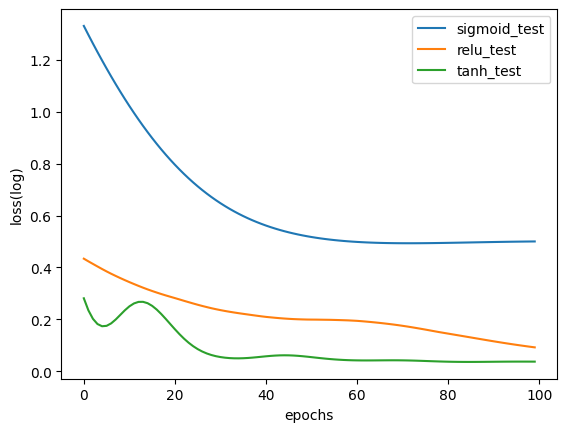

In [264]:
fig = plt.figure()
ax = fig.add_subplot()
# 学習曲線
# ax.plot(history.history["loss"], label = "train")
# 活性化関数tanhで学習した後のtanh_test
ax.plot(history.history["val_loss"], label = "sigmoid_test")
ax.plot(relu_history.history["val_loss"], label = "relu_test")
ax.plot(tanh_history.history["val_loss"], label = "tanh_test")

# ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [160]:
with open("history.json", "w") as f:
    json.dump(history.history, f)

with open("history.json", "r") as f:
    history = json.load(f)

In [162]:
history["loss"], history["val_loss"]

([0.8657496571540833,
  0.8494500517845154,
  0.8333494663238525,
  0.8174554109573364,
  0.8017687201499939,
  0.7862935066223145,
  0.7710320353507996,
  0.7559871673583984,
  0.7411612868309021,
  0.7265568971633911,
  0.712175726890564,
  0.6980196237564087,
  0.6840898990631104,
  0.6703881621360779,
  0.6569151282310486,
  0.6436717510223389,
  0.6306585073471069,
  0.6178755164146423,
  0.605323076248169,
  0.593001127243042,
  0.5809087753295898,
  0.5690460801124573,
  0.5574116706848145,
  0.5460047125816345,
  0.5348240733146667,
  0.5238682627677917,
  0.513135552406311,
  0.5026243329048157,
  0.49233278632164,
  0.4822584390640259,
  0.47239944338798523,
  0.46275320649147034,
  0.45331746339797974,
  0.4440895617008209,
  0.435066819190979,
  0.42624640464782715,
  0.4176255762577057,
  0.40920132398605347,
  0.40097057819366455,
  0.3929305672645569,
  0.38507798314094543,
  0.37740975618362427,
  0.36992284655570984,
  0.36261382699012756,
  0.35547956824302673,
  0.34

In [252]:
save_loss = list()
save_val_loss = list()
save_history = list()

#KFoldの設定
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

#交差検証
for train_index, test_index in kf.split(x, y):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    model = build_model(x)
    
    model.compile(loss=losses.MeanSquaredError(), 
              optimizer=optimizers.Adam(learning_rate = 0.00001))

    mc = callbacks.ModelCheckpoint(
        filepath = "model.h5",
        monitor = "val_loss",
        save_best_only = True,
        mode = "min"
    )

    history = model.fit(x_train, y_train, batch_size = len(x_train), epochs = 5, verbose = 1, 
                        validation_data=(x_test, y_test), callbacks =[mc])

    save_history.append(history.history)
    model = models.load_model("model.h5")
    
    best_val_loss = model.evaluate(x_test, y_test, verbose = False)

    best_loss = model.evaluate(x_train, y_train, verbose = False)

    save_val_loss.append(best_val_loss)
    save_loss.append(best_loss)

Epoch 1/5
1/1 [==============================] - 1s 656ms/step - loss: 1.0500 - val_loss: 0.3776
Epoch 2/5
1/1 [==============================] - 0s 83ms/step - loss: 1.0233 - val_loss: 0.3658
Epoch 3/5
1/1 [==============================] - 0s 68ms/step - loss: 0.9970 - val_loss: 0.3542
Epoch 4/5
1/1 [==============================] - 0s 51ms/step - loss: 0.9711 - val_loss: 0.3428
Epoch 5/5
1/1 [==============================] - 0s 64ms/step - loss: 0.9457 - val_loss: 0.3317
Epoch 1/5
1/1 [==============================] - 1s 529ms/step - loss: 0.7615 - val_loss: 1.5109
Epoch 2/5
1/1 [==============================] - 0s 50ms/step - loss: 0.7399 - val_loss: 1.4726
Epoch 3/5
1/1 [==============================] - 0s 50ms/step - loss: 0.7188 - val_loss: 1.4350
Epoch 4/5
1/1 [==============================] - 0s 53ms/step - loss: 0.6983 - val_loss: 1.3979
Epoch 5/5
1/1 [==============================] - 0s 52ms/step - loss: 0.6782 - val_loss: 1.3616
Epoch 1/5
1/1 [=======================

Text(0.5, 0, 'epochs')

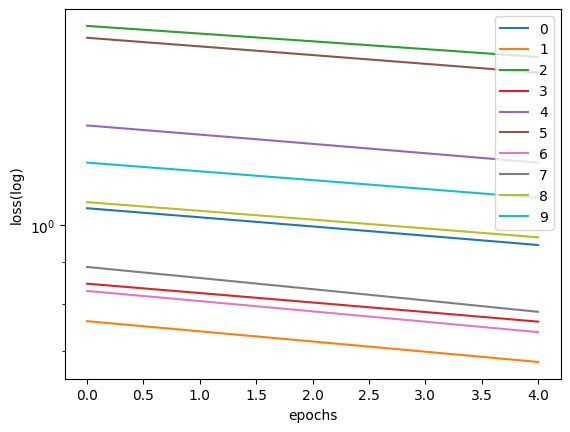

In [253]:
fig = plt.figure()
ax = fig.add_subplot()


# 学習曲線
# ax.plot(history.history["loss"], label = "train")
for i, H  in enumerate(save_history):
    H["loss"]
    # 活性化関数tanhで学習した後のtanh_test
    ax.plot(H["loss"], label = f"{i}")
    # ax.plot(H["val_loss"], label = "val_loss")

ax.set_yscale('log')
ax.legend()
ax.set_ylabel("loss(log)")
ax.set_xlabel("epochs")

In [223]:
max_save_loss = list()
min_save_loss = list()
max_save_val_loss = list()
min_save_val_loss = list()

max(save_loss), min(save_loss), max(save_val_loss), min(save_val_loss), np.average(save_loss), np.average(save_val_loss)


(0.020514072850346565,
 0.006870932411402464,
 0.07782904803752899,
 0.008683665655553341,
 0.014321782859042287,
 0.03579098302870989)

In [219]:
 model.evaluate(x_test, y_test, verbose = False)

0.0512220673263073